In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull

def generate_polygon (nr_sides, diameter,height):
    angles = np.linspace(0, 2 * np.pi, nr_sides, endpoint=False)
    x = diameter/2 * np.cos(angles)
    y = diameter/2 * np.sin(angles)
    z = np.full(nr_sides + 1 , height)

    verts = []
    verts = np.array(list(zip(x,y,z)))
    return verts


def plot_poly (points):
    convex = ConvexHull(points)
    simplices_poly = [[ convex.points[i] for i in y ] for y in convex.simplices]
    ax = plt.figure().add_subplot(projection='3d')
    poly = Poly3DCollection(simplices_poly, facecolors='w', edgecolor='b', linewidths=1, alpha=0.9)
    ax.add_collection3d(poly)
    plt.draw()
    

# Triangle pyramid

In [2]:
base_width = 800
height = 325
thickness = 20

In [3]:
base_triangle_height = np.sqrt(base_width**2 - (base_width/2)**2) 
side_triangle_height = np.sqrt(height**2 + (base_triangle_height/2)**2)
print(height)
print(side_triangle_height)
taper_angle_bottom = np.arcsin(height / side_triangle_height)
print(90 - taper_angle_bottom/(2* np.pi) * 360)
taper_angle_side = np.arcsin( base_width/2 / base_width)
print(taper_angle_side / (2 * np.pi) *360)

325
475.0
46.82644889274107
30.000000000000004


# General Simplex

[[ 6.00000000e+02  0.00000000e+00  0.00000000e+00]
 [ 3.00000000e+02  5.19615242e+02  0.00000000e+00]
 [-3.00000000e+02  5.19615242e+02  0.00000000e+00]
 [-6.00000000e+02  7.34788079e-14  0.00000000e+00]
 [-3.00000000e+02 -5.19615242e+02  0.00000000e+00]
 [ 3.00000000e+02 -5.19615242e+02  0.00000000e+00]
 [ 6.00000000e+02  0.00000000e+00  0.00000000e+00]
 [ 3.00000000e+02  4.50000000e+02 -2.59807621e+02]
 [-3.00000000e+02  4.50000000e+02 -2.59807621e+02]
 [-6.00000000e+02  6.36345143e-14 -3.67394040e-14]
 [-3.00000000e+02 -4.50000000e+02  2.59807621e+02]
 [ 3.00000000e+02 -4.50000000e+02  2.59807621e+02]]


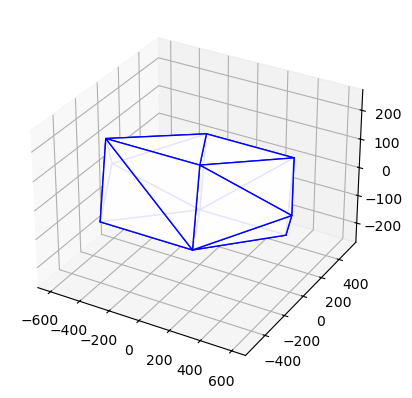

In [4]:
     

import numpy as np
import matplotlib.pyplot as plt

def edges_volume(points):
    simplices = ConvexHull(points)
    plates = []
    for (i,s1) in enumerate(simplices.simplices) :
        for (j,s2) in enumerate(simplices.simplices) :
            if j < i:
                continue
            if len(set(s1).intersection(s2)) == 2:
                #print(s1)
                d1 = [simplices.points[k] for k in s1]
                d2 = [simplices.points[k] for k in s2]
                
                v1 = np.cross(d1[0]-d1[2],d1[1]-d1[2])/ np.linalg.norm(np.cross(d1[0]-d1[2],d1[1]-d1[2]))
                v2 = np.cross(d2[0]-d2[2],d2[1]-d2[2])/ np.linalg.norm(np.cross(d2[0]-d2[2],d2[1]-d2[2]))
                alpha = np.arccos(max(min(np.inner(v1,v2), 0),-1)) / (2 * np.pi) * 360
                a = edge(s1,d1 ,s2,d2, set(s1).intersection(s2), alpha)
                plates.append(a)
    return plates

class edge:
    def __init__(self, simplex_index_1, simplex_coords_1, simplex_index_2, simplex_coords_2, edge_indices, taper_angle):
        self.adj_plates = [list(zip(simplex_index_1,simplex_coords_1)),
                           list(zip(simplex_index_2,simplex_coords_2))]
        self.edge_indices = edge_indices
        self.edge =  [(j,x) for (i,x) in zip(simplex_index_1,simplex_coords_1) for j in list(edge_indices) if i == j]
        self.taper_angle = taper_angle
        self.length = np.linalg.norm(self.edge[0][1]-self.edge[1][1])

class corner:
    def __init__(self, index, coord, adjacent_edges, angle):
        self.index = index
        self.coord = coord
        self.adjacent_edges = adjacent_edges
        self.angle = angle

class plate: 
    def __init__(self, indices, coords, corners, area):
        self.indices = indices
        self.coords = coords
        self.corners = corners
        self.area = area

class volume:
    def __init__(self,vertices):
        self.simplices = ConvexHull(vertices)
        self.edges = edges_volume(vertices)
        self.plates = []
        for s in self.simplices.simplices:
            coords = [self.simplices.points[k] for k in s]
            corners = []
            for i in s:
                adj_edges = []
                edge_vectors = []
                for j in [k for k in s if k != i]:
                    e = next((e for e in self.edges if set(e.edge_indices) == set([i,j]) ))
                    adj_edges.append(e)
                    edge_vectors.append(next(( x for (k, x) in e.edge if k == j)) - self.simplices.points[i])
                    #print(e.edge_indices)
                v1 = edge_vectors[0]/np.linalg.norm(edge_vectors[0])
                v2 = edge_vectors[1]/np.linalg.norm(edge_vectors[1])
                angle = np.arccos(max(min(abs(np.inner(v1,v2)),1),-1)) / (2 * np.pi) * 360
                area = np.linalg.norm(np.cross(edge_vectors[0],edge_vectors[1]))/2
                corners.append(corner(i,self.simplices.points[i], adj_edges,angle))
            self.plates.append(plate( s , coords, corners, area))
        self.corners = corners


def parse_volume(volume):
    for (np ,plate) in enumerate(volume.plates):
        #print(plate.coords)
        print("Platte nr", np)
        print(plate.indices)
        print(plate.coords)
        for c in plate.corners:
            #print(c.angle)
            print("Ecke", "index", c.index , "Position", c.coord)
            print("Winkel", c.angle)
            for e in c.adjacent_edges:
                #print(e.edge_indices)
                #print(e.taper_angle)
                print("Anliegende Kante", e.edge_indices)
                print("Taper", e.taper_angle)
                print("Länge", e.length)

s3d = np.array([[0, 0, 0], [400, 0, 0], [200, 500, 500], [200, 0, np.sqrt(400**2-200**2)]])
hex_skew_1 = np.array(generate_polygon(6,1200, 0))
w = 30/360 * 2 * np.pi
rot = np.array([[1,0,0],
         [0,np.cos(w),-np.sin(w)],
         [0,np.sin(w),np.cos(w)]])
hex_skew_2 = np.array(generate_polygon(6,1200, 0))
hex_skew = np.vstack((hex_skew_1, hex_skew_2 @ rot) )
#s3d = np.array([[0, 0, 0], [400, 0, 0], [200, 500, np.sqrt(400**2-200**2)/2], [200, 0, np.sqrt(400**2-200**2)]])
#s3d = np.array([[-1, 0, 0], [1, 0, 0], [0,1,0], [0,-1,0],[0,0,1]])
print(hex_skew)
plot_poly(hex_skew)

#print(volume(s3d).plates)

In [10]:
import drawsvg as draw

def normalize(vector):
    return vector/np.linalg.norm(vector)

def draw_plates (volume):
    i = 0
    for p in volume.plates:
        d = p.coords
        angle = np.arcsin(np.linalg.norm(np.cross(normalize(d[1]-d[0]),normalize(d[2]-d[0]))))
        p3 = [np.linalg.norm(d[2]-d[0]) * np.cos(angle),
              np.linalg.norm(d[2]-d[0]) * np.sin(angle)]
        points = [(p.indices[0], [0,0]),
                  (p.indices[1], [np.linalg.norm(d[1]-d[0]),0]),
                  (p.indices[2],p3)]
        s = draw.Drawing(2000, 2000,origin='center')
        s.append(draw.Lines(points[0][1][0], points[0][1][1],
                            points[1][1][0], points[1][1][1],
                            points[2][1][0], points[2][1][1],
                            close = True,
                            stroke = 'black', fill='#ffffff'
                            ),
                 )
        for c in p.corners:
            arr_index = list(p.indices).index(c.index)
            s.append(draw.Text("Nr. " + str(c.index) + ", " + str(int(c.angle)) + "°",
                               8,
                               points[arr_index][1][0],
                               points[arr_index][1][1],
                               fill='blue'
                               )
                     )
            for e in c.adjacent_edges:
                index_list = list([ list(p.indices).index(t) for t in e.edge_indices])
                s.append(draw.Text(str(int(e.length)) + "mm, " + str(int(e.taper_angle)) + "°",
                                   8,
                                   (points[index_list[0]][1][0] + points[index_list[1]][1][0])/2,
                                   (points[index_list[0]][1][1] + points[index_list[1]][1][1])/2,
                                   fill='blue')
                         )
        for k in volume.plates:
            if len(set(k.indices).intersection(set(p.indices))) == 2:
                coincidence = set(k.indices).intersection(set(p.indices))
                print
                for z in k.corners:
                    for e in z.adjacent_edges:
                        if set(e.edge_indices) == coincidence and (int(e.taper_angle) == 0 or int(e.taper_angle) == 180):
                            print("hello")
        s.save_svg('skew_hex' + str(i) + '.svg')
        i += 1

draw_plates(volume(hex_skew))


hello
hello
hello
hello
hello
hello
hello
hello
